## Task

In this exercise, you will train an agent to interact and win in a not-so-friendly environment. Classically, the task is as follows: an agent and friends played frisbee (flying saucer) on the shore of a beautiful lake in early spring. As a result of an unsuccessful throw, the saucer landed on the surface of a partially frozen lake. The lake has areas with solid ice (white squares) and areas with thawed areas (black squares). The task of the agent is to go from the starting point to the point where the plate falls (finish), bypassing the thawed patches. An example of a possible lake configuration is shown in the figure.  


---

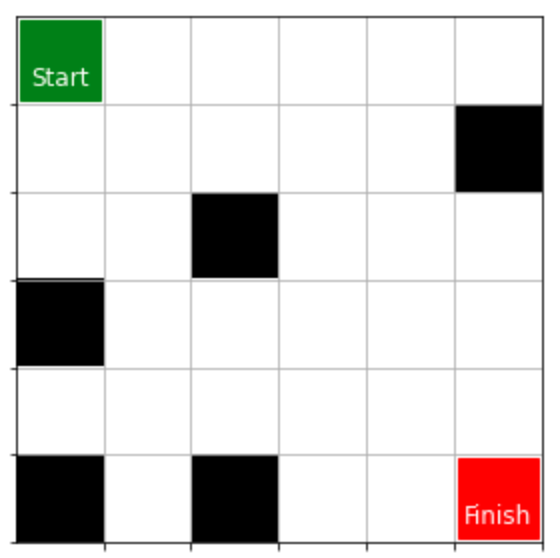

Four actions are available to the agent: left, up, right, and down. The game ends if the number of steps is exhausted (in our case it is 100), the agent falls under the water (black cell) or still reaches the Frisbee plate (finish). In the latter case, he receives a +1 reward, in all other cases, the reward is zero.

Simulate the interaction between the agent and the environment. For training, use the Q-learning algorithm. As a strategy, use the -greedy strategy with epsilon = 0.1. Discount factor gamma = 0.8. Set the parameter random_seed = 6.

In [94]:
# hyperparameters
epsilon = 0.1 # the epsilon parameter when using the greedy strategy epsilon
gamma = 0.8 # gamma discount factor
random_seed = 6 # random seed
time_delay = 1 # time delay when rendering the game process after training (seconds)
lr_rate = 0.9 # alpha learning rate coefficient

We import the libraries, create our own 6x6 environment. S denotes the starting point. F - ice is safe, H - thaw, G - goal. The `is_slippery=False` parameter is responsible for the conditional lack of slipping. That is, if the agent has chosen the action to go to the right, then he will move to the corresponding state. In the general case, due to "sliding" one can end up in a different state. We also copied from the GYM library and slightly modified the ```generate_random_map ``` function to generate random maps based on ```random_seed ```.

In [95]:
import gym
import numpy as np
import time
from IPython.display import clear_output


def generate_random_map(size, p, sd):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False
    np.random.seed(sd)

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0,0))
        while frontier:
            r, c = frontier.pop()
            if not (r,c) in discovered:
                discovered.add((r,c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] not in '#H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]

# map generation
random_map = generate_random_map(size=6, p=0.8, sd = random_seed) # create our map
env = gym.make("FrozenLake-v0", desc=random_map, is_slippery=False) # environment initialization
print("Map")
env.render() # print map

Map

SFHFFF
FFFFFF
FFFHHF
HHFFHF
FFFHFF
FHFFFG


Functions for choosing an action and updating the action value table.  
The learn() function updates the value of the current action according to the Q-learning algorithm.

In [96]:
def choose_action(state):
    action=0
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0,env.action_space.n)
    else:
        action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

def learn(state, state2, reward, action, done):
    Q[state, action] = Q[state, action] + lr_rate * (reward + gamma * max(Q[state2, :]) - Q[state, action])

The following code, as a result of training the model, can indicate the number of wins and the number of the game (game) in which the agent won the fifth win in a row for the first time.

Let's explain what the ```env.step(action)``` function returns

```state2``` -- next state

```reward``` -- reward

```done``` -- game end flag. True if you win or fall into a thaw. False otherwise.

In [97]:
from tqdm import tqdm

# inititalization
np.random.seed(random_seed)
total_games = 10000
max_steps = 100
Q = np.zeros((env.observation_space.n, env.action_space.n))
totalWins = 0
fifthWinInRowId = -1
winInRowCounter = 0
inRowCountFlag = True

# main cycle
for game in tqdm(range(total_games)):
    state = env.reset()
    t = 0
    while t < max_steps:
        
        t += 1

        action = choose_action(state)

        state2, reward, done, info = env.step(action)

        if t == max_steps:
            done = True  

        learn(state, state2, reward, action, done)

        state = state2

        if done:
            break

    if reward == 1:
        totalWins += 1
        winInRowCounter += 1
    else:
      winInRowCounter = 0

    if inRowCountFlag and (winInRowCounter == 5):
        fifthWinInRowId = game + 1
        inRowCountFlag = False

100%|██████████| 10000/10000 [00:07<00:00, 1395.45it/s]


In [98]:
print("Number of wins in a series of 10,000 games: ", totalWins)
print("Five wins in a row for the first time in a game: ", fifthWinInRowId)

Number of wins in a series of 10,000 games:  2202
Five wins in a row for the first time in a game:  7473


Let's make one game to follow the actions of the agent. In this case, we will consider the model to be fully trained, that is, the actions are chosen greedily, the values of the action values in the table are not updated.

In [99]:
import time
# greedy choice of actions
def choose_action_one_game(state):
    action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

states=[] # an array to save the states of the agent during the game
t = 0
state = env.reset()
wn = 0
while(t < 100):
  env.render()
  time.sleep(time_delay)
  clear_output(wait=True)
  action = choose_action_one_game(state)  
  state2, reward, done, info = env.step(action)  
  states.append(state)
  state = state2
  t += 1
  if done and reward == 1:
    wn=1
  if done:
    break
if wn == 1:
  print("Win")

Win


Let's display the route

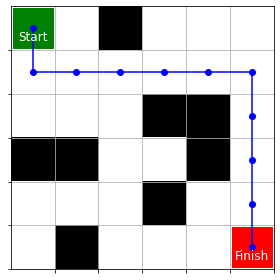

In [100]:
import matplotlib.pyplot as plt

def make_maze_pic(maze):
  maze_pic=[]
  for i in range(len(maze)):
    row = []
    for j in range(len(maze[i])):
      if maze[i][j] == 'S':
        row.append(0)
      if maze[i][j] == 'F':
        row.append(0)
      if maze[i][j] == 'H':
        row.append(1)
      if maze[i][j] == 'G':
        row.append(0)
    maze_pic.append(row)
  maze_pic = np.array(maze_pic)
  return maze_pic
  

# make maze fit to plot
maze_pic = make_maze_pic(random_map)
nrows, ncols = maze_pic.shape

# arrays of picture elements
rw = np.remainder(states,nrows)
cl = np.floor_divide(states,nrows)
if wn == 1:
  rw = np.append(rw, [nrows-1])
  cl = np.append(cl,[ncols-1])

# picture plotting
fig, ax1 = plt.subplots(1, 1, tight_layout=True)
ax1.clear()
ax1.set_xticks(np.arange(0.5, nrows, step=1))
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0.5, ncols, step=1))
ax1.set_yticklabels([])
ax1.grid(True)
ax1.plot([0],[0], "gs", markersize=40)  # start is a big green square
ax1.text(0, 0.2,"Start", ha="center", va="center", color="white", fontsize=12) #Start text
ax1.plot([nrows-1],[ncols-1], "rs", markersize=40)  # exit is a big red square
ax1.text(nrows-1, ncols-1+0.2,"Finish", ha="center", va="center", color="white", fontsize=12) #Exit text
ax1.plot(rw,cl, ls = '-', color = 'blue') #Blue lines path
ax1.plot(rw,cl, "bo")  # Blue dots visited cells
ax1.imshow(maze_pic, cmap="binary")

We duplicate the resulting notebook and use the SARSA algorithm instead of the Q-learning algorithm. Please note that the task requires you to change the number of games. That is, `total_games = 40000`. Blocks should be launched sequentially from the very beginning (due to `random_seed`). Separately, we draw your attention to the fact that when changing the algorithm from Q-learning to SARSA, both the learning process and the `learn()` function are subject to modification. In addition, the `learn()` function must have an additional argument (next action).

In [101]:
# map generation
random_map = generate_random_map(size=6, p=0.8, sd = random_seed) # create our map
env = gym.make("FrozenLake-v0", desc=random_map, is_slippery=False) # environment initialization
print("Map")
env.render() # print map

Map

SFHFFF
FFFFFF
FFFHHF
HHFFHF
FFFHFF
FHFFFG


In [102]:
def choose_action(state):
    action = 0
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0,env.action_space.n)
    else:
        action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

def learn(state, state2, reward, action, action2, done):
    Q[state, action] = Q[state, action] + lr_rate * (reward + gamma * Q[state2, action2] - Q[state, action])

In [103]:
from tqdm import tqdm

# inititalization
np.random.seed(random_seed)
total_games = 40000
max_steps = 100
Q = np.zeros((env.observation_space.n, env.action_space.n))
totalWins = 0
fifthWinInRowId = -1
winInRowCounter = 0
inRowCountFlag = True

# main cycle
for game in tqdm(range(total_games)):
    state = env.reset()
    t = 0
    action = choose_action(state)
    while t < max_steps:
              
        t += 1

        state2, reward, done, info = env.step(action)

        action2 = choose_action(state2) # choosing an action both for the next step of the game and for updating the value of the completed action

        if t == max_steps:
          done = True  

        learn(state, state2, reward, action, action2, done)

        state = state2

        action = action2

        if done:
            break

    if reward == 1:
        totalWins += 1
        winInRowCounter += 1
    else:
      winInRowCounter = 0

    if inRowCountFlag and (winInRowCounter == 5):
        fifthWinInRowId = game + 1
        inRowCountFlag = False

100%|██████████| 40000/40000 [00:39<00:00, 1018.12it/s]


In [104]:
print("Number of wins in a series of 40,000 games: ", totalWins)
print("Five wins in a row for the first time in a game: ", fifthWinInRowId)

Number of wins in a series of 40,000 games:  29241
Five wins in a row for the first time in a game:  1399


In [105]:
import time
# greedy choice of actions
def choose_action_one_game(state):
    action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

states=[] # an array to save the states of the agent during the game
t = 0
state = env.reset()
wn = 0
while(t < 100):
  env.render()
  time.sleep(time_delay)
  clear_output(wait=True)
  action = choose_action_one_game(state)  
  state2, reward, done, info = env.step(action)  
  states.append(state)
  state = state2
  t += 1
  if done and reward == 1:
    wn=1
  if done:
    break
if wn == 1:
  print("Win")

Win


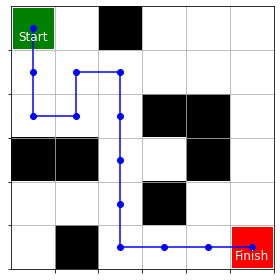

In [106]:
import matplotlib.pyplot as plt

def make_maze_pic(maze):
  maze_pic=[]
  for i in range(len(maze)):
    row = []
    for j in range(len(maze[i])):
      if maze[i][j] == 'S':
        row.append(0)
      if maze[i][j] == 'F':
        row.append(0)
      if maze[i][j] == 'H':
        row.append(1)
      if maze[i][j] == 'G':
        row.append(0)
    maze_pic.append(row)
  maze_pic = np.array(maze_pic)
  return maze_pic
  

# make maze fit to plot
maze_pic = make_maze_pic(random_map)
nrows, ncols = maze_pic.shape

# arrays of picture elements
rw = np.remainder(states,nrows)
cl = np.floor_divide(states,nrows)
if wn == 1:
  rw = np.append(rw, [nrows-1])
  cl = np.append(cl,[ncols-1])

# picture plotting
fig, ax1 = plt.subplots(1, 1, tight_layout=True)
ax1.clear()
ax1.set_xticks(np.arange(0.5, nrows, step=1))
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0.5, ncols, step=1))
ax1.set_yticklabels([])
ax1.grid(True)
ax1.plot([0],[0], "gs", markersize=40)  # start is a big green square
ax1.text(0, 0.2,"Start", ha="center", va="center", color="white", fontsize=12) #Start text
ax1.plot([nrows-1],[ncols-1], "rs", markersize=40)  # exit is a big red square
ax1.text(nrows-1, ncols-1+0.2,"Finish", ha="center", va="center", color="white", fontsize=12) #Exit text
ax1.plot(rw,cl, ls = '-', color = 'blue') #Blue lines path
ax1.plot(rw,cl, "bo")  # Blue dots visited cells
ax1.imshow(maze_pic, cmap="binary")